**Arjun Krishnan - 6622982 - Natural Language Processing, Individual component - Notebook 2**
# Experiment 3 - Word2Vec word embeddings

 For our third experiment we use WordVec embeddings and see how it affects our model's performance. Wor2vec embeddings has been used in the world of NLP for a while, has been proven to provide very good results in tasks such as sentence classification. In essence, The word2Vec tool takes a text corpus as input and produces the word vectors as output and if the word is not avaible we assign a random vector to it.

  We use Google's Word2vec model trained on about 100 billion words. The model contains 300-dimensional vectors for 3 million words and phrases. Many have had success using this Word2Vec tool. We use this pre-trained Word2Vec on our data and see if it has any impact on the models trained in the previous notebook. 

**Google's Pre trained word embeddings:**
https://code.google.com/archive/p/word2vec/

In [1]:
#checking if we are using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#checking if the available ram is used
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [31]:
#Installing and importing the required libraries
!pip install unidecode
!pip install contractions
!pip install tensorflow-addons

import pandas as pd
import numpy as np
import matplotlib as plt
import re
import nltk
import sklearn
import gensim
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa
import sklearn
import seaborn as sns
import math

from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras import regularizers
from tensorflow.python.keras.layers import Input, Activation, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Lambda, \
Conv2DTranspose, Permute, GaussianNoise, advanced_activations, Add, LeakyReLU, Dropout, ActivityRegularization
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

In [4]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#choosing directory
import os
os.chdir("./drive/MyDrive/NLPCW/")

In [6]:
os.listdir()

['Questions.csv',
 'Tags.csv',
 'GoogleNews-vectors-negative300.txt',
 'exp2_data.csv',
 'model2-EXP3.h5',
 'model2-EXP2.h5',
 'model3-NLPCW.h5',
 'model4-NLPCW.h5',
 'model5-NLPCW.h5',
 'model6-NLPCW.h5',
 'corpus_word2vec.txt',
 'preprocdata.csv',
 'preprocstats.csv',
 'model1-NLPCW.h5',
 'model2-NLPCW.h5']

In [7]:
#Reading the pre-processed data from notebook 1
df = pd.read_csv('preprocdata.csv')

In [8]:
df.head(1)

,Text,anova,bayesian,classification,clustering,correlation,distributions,hypothesis testing,logistic,machine learning,mathematical statistics,mixed model,multiple regression,neural networks,normal distribution,probability,r,regression,self study,statistical significance,time series
0,"['culture', 'statistic', 'v', 'machine_learnin...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#Reading the class weights from notebook 1
df_stats = pd.read_csv('preprocstats.csv')
df_stats

,category,count,class_weight
0,anova,2505,31.946906
1,bayesian,2656,30.130648
2,classification,2881,27.777508
3,clustering,1952,40.997439
4,correlation,2871,27.874260
5,distributions,3501,22.858326
6,hypothesis testing,3869,20.684156
7,logistic,3316,24.133595
8,machine learning,6089,13.142881
9,mathematical statistics,1888,42.387182


In [10]:
sequence_length=300
num_filters = 300
class_weight = dict(df_stats.class_weight)

In [11]:
# this is the number of words we care about
max_features = 200000 

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['Text'].values)

#this takes our sentences and replaces each word with an integer
x = tokenizer.texts_to_sequences(df['Text'].values)

#we then pad the sequences so they're all the same length (sequence_length)
x = pad_sequences(x, sequence_length)
y = df.iloc[:, 1:]

#where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 9000)

In [12]:
#checking for the number of words in the word2vec model
embeddings_index = {}
import os
f = open('GoogleNews-vectors-negative300.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in Google word2vec model' % len(embeddings_index))

Found 3000000 word vectors in Google word2vec model


In [13]:
#Number of  unique tokens in our data
word_index = tokenizer.word_index
print('Found %s unique tokens in our data' % len(word_index))

Found 79817 unique tokens in our data


In [14]:
#we run through all the words in our tokenizer to look for them in the w2v model
#If they exist in Google's Word2Vec we add them to our embedding matrix, if they don't then we assign a random vector to them
#code referenced from stack-overflow
max_features = 200000
embedding_dim = 300
num_words = min(max_features, len(word_index)) + 1
print(num_words)

#we create a embedding matrix with zeroes
embedding_matrix = np.zeros((num_words, embedding_dim))

#Find words from tokenizer in the word2Vec model and assign a random vector if they are not
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

79818


# CNN3 - Static Word2Vec
The model from previous notebook is used along with Wor2Vec embeddings with the following parameters:
1. Embedding Dimension = 300
2. Non-Trainable embeddings
3. Number of Epochs = 10
4.  Batch size set to 64 as it results in better performance as seen from notebook 1.

Batch size of 64 and 10 Epochs is used as it works best, as seen from notebook 1. 


In [19]:
#model building
max_words = 200000
filter_length = 300
maxlen = 300
num_classes = 20

model3 = Sequential()

inputs = Input(shape=(sequence_length,), dtype='int32')

model3.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=False))

model3.add(Dropout(0.1))
model3.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model3.add(GlobalMaxPool1D())
model3.add(Dense(num_classes))
model3.add(Activation('sigmoid'))

model3.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])

model3.summary()

callbacks = [ReduceLROnPlateau(), 
            EarlyStopping(patience=4), 
            ModelCheckpoint(filepath='model3-NLPCW.h5', save_best_only=True)
]

history3 = model3.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          23945400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 300)          270300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6020      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
Total params: 24,221,720
Trainable params: 276,320
Non-trainable params: 23,945,400
____________________________________

In [22]:
CNN3 = keras.models.load_model('model3-NLPCW.h5') 

In [23]:
metrics = CNN3.evaluate(x_test, y_test)
print("The metrics for CNN model 3 on testing data:")
print("{}: {}".format(model3.metrics_names[0], metrics[0]))
print("{}: {}".format(model3.metrics_names[1], metrics[1]))
print("{}: {}".format(model3.metrics_names[2], metrics[2]))
print("{}: {}".format(model3.metrics_names[3], metrics[3]))
print("{}: {}".format(model3.metrics_names[4], metrics[4]))

177/177 [==============================] - 1s 5ms/step - loss: 0.1476 - micro-f1: 0.5585 - macro-f1: 0.5549 - binary-accuracy: 0.9479 - categorical-accuracy: 0.5591
The metrics for CNN model 3 on testing data:
loss: 0.1476493775844574
micro-f1: 0.5585164427757263
macro-f1: 0.5549454689025879
binary-accuracy: 0.9478905200958252
categorical-accuracy: 0.5591207146644592


In [24]:
#printing the Hamming loss for model 3
print('Hamming loss for CNN3: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model3.predict(x_test).round(), sample_weight=None)))

Hamming loss for CNN3: 0.053580925367842584


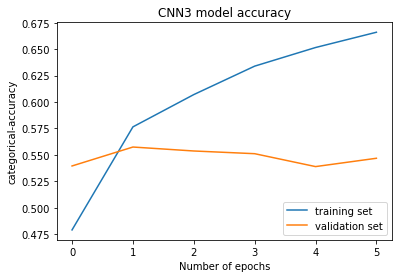

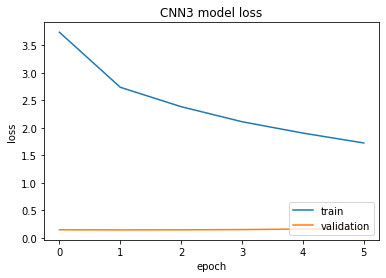

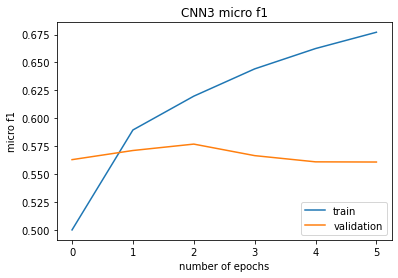

In [25]:
plt.plot(history3.history['categorical-accuracy'])
plt.plot(history3.history['val_categorical-accuracy'])
plt.title('CNN3 model accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('CNN3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history3.history['micro-f1'])
plt.plot(history3.history['val_micro-f1'])
plt.title('CNN3 micro f1')
plt.ylabel('micro f1')
plt.xlabel('number of epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [26]:
#code for confusion matrix of a multilabel problem
confusion_matrix3 = sklearn.metrics.multilabel_confusion_matrix(y_test, model3.predict(x_test).round(), sample_weight=None)

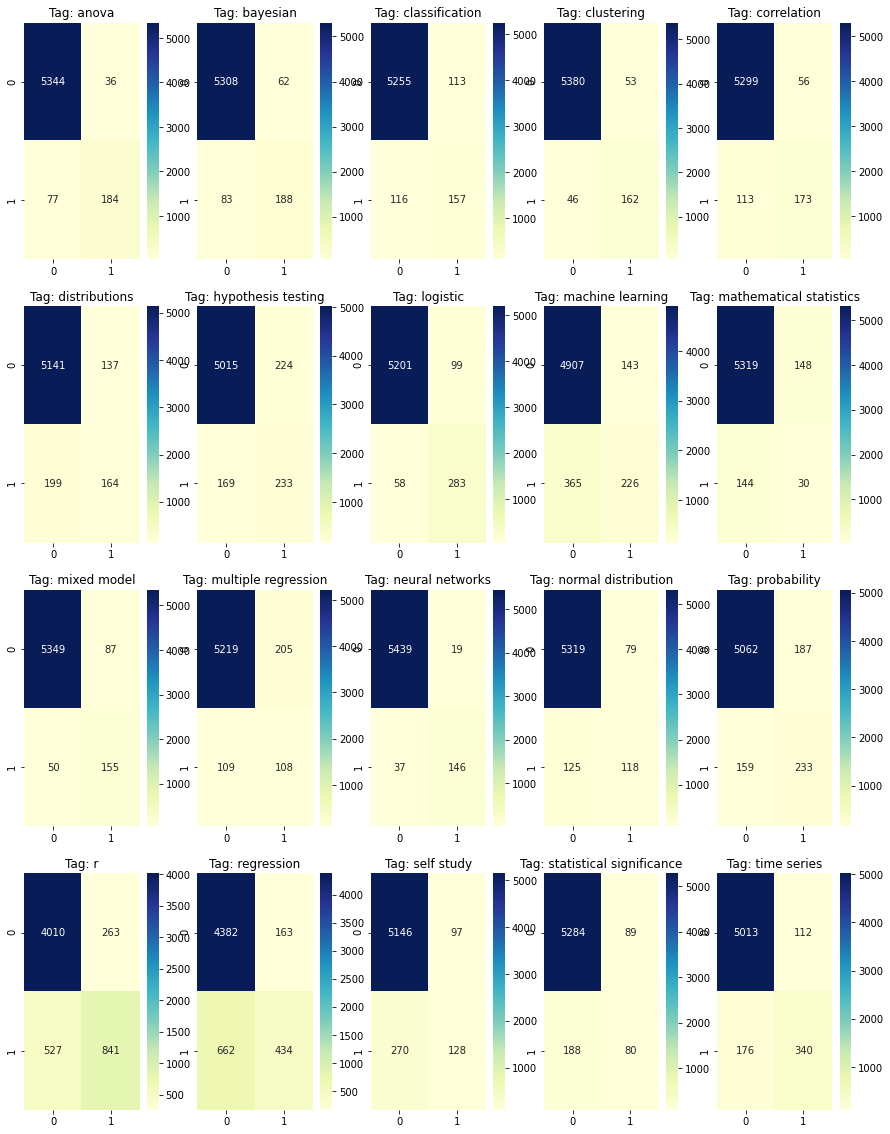

In [33]:
#plotting the confusion matrix for each labels
labelnames = df_stats['category']
labelnames = list(labelnames)

fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix3[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

**Model comparison:**


|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |
|CNN 3 | 0.0535     | 0.5585 |  0.5549 |    0.9478     |       0.5591         |

After using Wor2Vec embeddings, with similar hyperparameters as CNN2(model 2) the model's performance has droppped a little when compared to CNN2. This could be because a number of our corpus tokens might not have been found in Word2Vec model, thus resulting in a drop in performance.


# Experiment 4 - CNN 4 - Non static Word2Vec
we continue with our experimentation from our previous model by changing the setup and some of the Hyperparameters. 

The following changes were made:
1. Changed to trainable embedding(non-static) from non-trainable(static) Word2Vec to compare the performance, as we obtained better results with trainable embeddings as seen in notebook 1. 
2. Number of epochs changed to 30 for experiemntal purposes.
3. Batch size is kept the same, as it performs better after experimentation.

In [34]:
model4 = Sequential()

inputs = Input(shape=(sequence_length,), dtype='int32')

model4.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))

model4.add(Dropout(0.1))
model4.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model4.add(GlobalMaxPool1D())
model4.add(Dense(num_classes))
model4.add(Activation('sigmoid'))

model4.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])

model4.summary()

callbacks = [ReduceLROnPlateau(), 
            EarlyStopping(patience=6), 
            ModelCheckpoint(filepath='model4-NLPCW.h5', save_best_only=True)
]

history4 = model4.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          23945400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 300)          270300    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                6020      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
Total params: 24,221,720
Trainable params: 24,221,720
Non-trainable params: 0
__________________________________________

In [39]:
#loading the model
CNN4 = keras.models.load_model('model4-NLPCW.h5') 

In [40]:
#printing the mterics
metrics = CNN4.evaluate(x_test, y_test)
print("The metrics for CNN model 4 on testing data:")
print("{}: {}".format(model4.metrics_names[0], metrics[0]))
print("{}: {}".format(model4.metrics_names[1], metrics[1]))
print("{}: {}".format(model4.metrics_names[2], metrics[2]))
print("{}: {}".format(model4.metrics_names[3], metrics[3]))
print("{}: {}".format(model4.metrics_names[4], metrics[4]))

177/177 [==============================] - 1s 5ms/step - loss: 0.1529 - micro-f1: 0.5414 - macro-f1: 0.5445 - binary-accuracy: 0.9467 - categorical-accuracy: 0.5439
The metrics for CNN model 4 on testing data:
loss: 0.15292271971702576
micro-f1: 0.5414324402809143
macro-f1: 0.544543445110321
binary-accuracy: 0.946675717830658
categorical-accuracy: 0.5438752174377441


In [41]:
#printing the Hamming loss for model 4
print('Hamming loss for CNN4: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model4.predict(x_test).round(), sample_weight=None)))

Hamming loss for CNN3: 0.056408438220173725


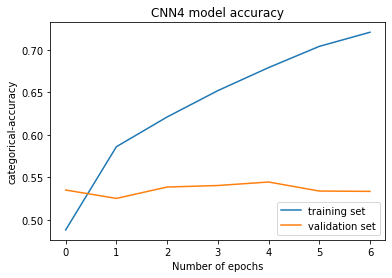

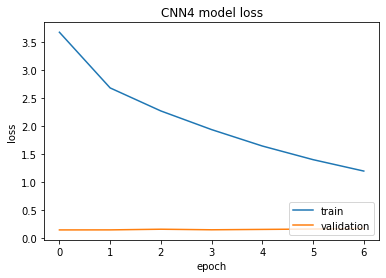

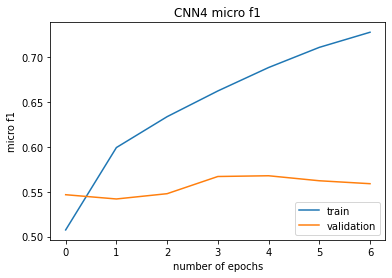

In [42]:
#Plotting model's accuracy, loss and f1 score
plt.plot(history4.history['categorical-accuracy'])
plt.plot(history4.history['val_categorical-accuracy'])
plt.title('CNN4 model accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('CNN4 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history4.history['micro-f1'])
plt.plot(history4.history['val_micro-f1'])
plt.title('CNN4 micro f1')
plt.ylabel('micro f1')
plt.xlabel('number of epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [43]:
confusion_matrix4 = sklearn.metrics.multilabel_confusion_matrix(y_test, model4.predict(x_test).round(), sample_weight=None)

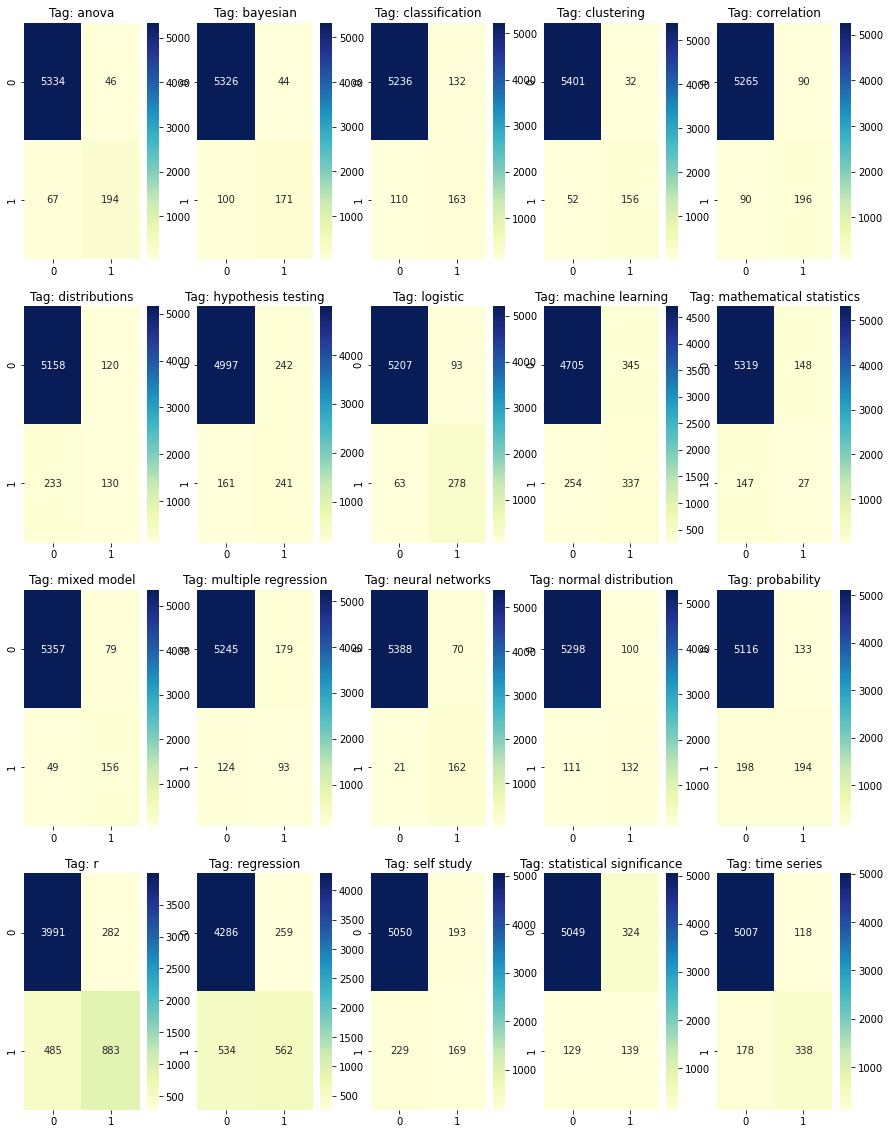

In [44]:
#plotting the confusion matrix for each labels
labelnames = df_stats['category']
labelnames = list(labelnames)

fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix4[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

**Model comparison:**


|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |
|CNN 3 | 0.0535     | 0.5585 |  0.5549 |    0.9478     |       0.5591         |
|CNN 4 | 0.0564     | 0.5414 |  0.5445 |    0.9466     |       0.5438         |
 
CNN 4's performance had dropped even further, while highly overfitting the training data after setting the embeddings to be trainable. 

The results from Experiments 3 and 4 with  pre trained Word2Vec have not been satisfactory, the reason for this is could be because of the data at hand. The data has information about intricate techical difficulties faced by others that withold highly technical information, posted on stack exchange.  A lot of these words/terms couldve have been missing in the pre-trained word2vec model,  assigning a random vector to the missing words might have led to higher losses and drop in accuracy and F1 scores when compared to Random embeddings in notebook 1. 

**Next steps:**
In the next notebook, I aim to adapt the model from Yoon Kim's research paper pushiled in 2014, the 2D Convolutional Neural Net that performed really well for sentence classificication tasks back in its time and compare it's performance with our other experiments.